In [12]:
import yfinance as yf
import seaborn as sns
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# List of ETF tickers
# symbols = sorted(["HYG", "EFA", "VWO", "IYR", "GLD"]) # , "ABTC.SW"

# Define a list of index tickers
symbols = sorted([
    "SPY",  # S&P 500
    "CSSX5E.SW",  # Euro Stoxx 50
    "CSUKX.SW",  # FTSE 100
    "NDIA.L",  # BSE Sensex
    "IEMA.L",  # MSCI Emerging Markets Index
    # "IWDA.L",  # Global Investment ETF
    "XS2D.L"  # S&P 500 2x Leveraged
])

list_max_return = []
list_std_dev = []
list_max_return_allocation = []
list_max_return_startdate = []

# Estimate inflation and fees
inflation_year = 0.03
fee_year_msciworld = 0.002
fee_year_allw = 0.004

In [13]:
def generate_simulation(days_to_add, show_plots, show_logs):

  num_simulations = 2 * 10**4
  inflation_flag = False
  fee_flag = False

  print(f"\ndays_to_add: {days_to_add}")

  if show_logs:
    print(f"\nnum_simulations: {num_simulations}")

  # Annualization days
  annualization_days = 252

  # Estimate inflation
  inflation_daily = 0
  if inflation_year > 0:
    inflation_daily = (1 + inflation_year) ** (1 / annualization_days) - 1
    inflation_flag = True
  if show_logs:
    print(f"inflation_daily: {inflation_daily:.4%}")

  # Estimate fees
  fee_daily_msciworld = 0
  if fee_year_msciworld > 0:
   fee_daily_msciworld = (1 + fee_year_msciworld) ** (1 / annualization_days) - 1
   fee_flag = True
  if show_logs:
    print(f"fee_daily_msciworld: {fee_daily_msciworld:.4%}")

  fee_daily_allw = 0
  if fee_year_allw > 0:
   fee_daily_allw = (1 + fee_year_allw) ** (1 / annualization_days) - 1
   fee_flag = True
  if show_logs:
    print(f"fee_daily_allw: {fee_daily_allw:.4%}")

  start_date = "2018-08-31"
  start_date = datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=days_to_add)
  end_date = "2024-01-31"

  data = yf.download(symbols, start=start_date, end=end_date)

  # Calculate daily returns
  returns = data['Adj Close'].pct_change().dropna()

  # Download historical stock price data
  symbol_msciworld = "IWDA.L"
  data_msciworld = yf.download(symbol_msciworld, start=start_date, end=end_date)

  # Calculate daily returns
  return_msciworld = data_msciworld['Adj Close'].pct_change().dropna()


  if show_plots:
    # Create a correlation matrix with a color scale
    correlation_matrix = returns.corr()
    # Create a figure
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='coolwarm',
                linewidths=0.5,
                fmt=".2f",
                xticklabels=symbols,
                yticklabels=symbols)

    plt.title('Correlation Matrix of ETF Ticker Symbols')
    plt.show()

  # Calculate annualized returns
  annual_returns = returns.mean() * annualization_days

  annual_return_msciworld = return_msciworld.mean() * annualization_days
  annual_std_dev_msciworld = return_msciworld.std() * np.sqrt(annualization_days)

  # Initialize portfolio value
  initial_investment = 10**4
  portfolio_value_msciworld = initial_investment

  # Initialize lists to save simulation results
  portfolio_returns = []
  portfolio_std_dev = []
  allocation_list = []

  breakpoint = False

  # Monte Carlo simulation
  for _ in range(num_simulations):

      # Generate a random allocation of the three stocks
      allocations = np.random.random(len(symbols))
      allocations /= np.sum(allocations)  # Ensure allocations sum to 1

      for alloc in allocations:
        if alloc < 0.05 or alloc > 0.8:
          breakpoint = True
          break
      if breakpoint:
        breakpoint = False
        continue

      # Calculate the expected portfolio return
      expected_portfolio_return = np.sum(allocations * annual_returns)

      # Calculate the portfolio standard deviation
      portfolio_std = np.sqrt(np.dot(allocations.T, np.dot(returns.cov() * annualization_days, allocations)))

      # Add results to lists
      portfolio_returns.append(expected_portfolio_return)
      portfolio_std_dev.append(portfolio_std)
      allocation_list.append(allocations)

  def calculate_portfolio_value(returns, allocation, initial_investment, inflation_flag, inflation_daily, fee_flag, fee_daily_allw):
    portfolio_values = []
    portfolio_value = initial_investment
    for index, row in returns.iterrows():
        daily_returns = np.dot(row.values, allocation)
        portfolio_value *= (1 + daily_returns)
        if inflation_flag:
            portfolio_value *= (1 - inflation_daily)
        if fee_flag:
            portfolio_value *= (1 - fee_daily_allw)
        portfolio_values.append(portfolio_value)
    return portfolio_values

  # Calculate the MSCI World portfolio value for each day
  portfolio_msciworld_values = []
  for daily_return_msciworld in return_msciworld:
      portfolio_value_msciworld *= (1 + daily_return_msciworld)
      if inflation_flag:
          portfolio_value_msciworld *= (1 - inflation_daily)
      if fee_flag:
          portfolio_value_msciworld *= (1 - fee_daily_msciworld)
      portfolio_msciworld_values.append(portfolio_value_msciworld)

  # Total Return
  total_value_msciworld = (portfolio_value_msciworld / initial_investment) - 1

  if show_logs:
    print(f"\nMSCI World Annual Return: {annual_return_msciworld:.2%}")
    print(f"MSCI World Standard Deviation: {annual_std_dev_msciworld:.2%}")
    print(f"Total MSCI World Return: {total_value_msciworld:.2%}")

  # Find the allocation that maximizes return with minimum standard deviation
  max_return_index = np.argmax(portfolio_returns)
  optimal_allocation = allocation_list[max_return_index]
  optimal_return = portfolio_returns[max_return_index]
  optimal_std_dev = portfolio_std_dev[max_return_index]

  # Calculate the value of the Maximum Return portfolio for each day
  portfolio_max_value_values = calculate_portfolio_value(returns, optimal_allocation, initial_investment, inflation_flag, inflation_daily, fee_flag, fee_daily_allw)

  # Total Return
  total_value_max_value = (portfolio_max_value_values[len(portfolio_max_value_values) - 1] / initial_investment) - 1

  list_max_return.append(total_value_max_value)
  list_std_dev.append(optimal_std_dev)
  list_max_return_allocation.append(optimal_allocation)
  list_max_return_startdate.append(start_date)

  if show_logs:
    # Print the optimal allocation for maximum return
    print("\nOptimal Allocation for Maximum Return:")
    for symbol, alloc in zip(symbols, optimal_allocation):
        print(f"{symbol}: {alloc:.2%}")
    print(f"Annual Return: {optimal_return:.2%}")
    print(f"Standard Deviation: {optimal_std_dev:.2%}")
    print(f"Total Return: {total_value_max_value:.2%}")

  # Find the allocation that minimizes standard deviation
  min_std_dev_index = np.argmin(portfolio_std_dev)
  min_std_dev_allocation = allocation_list[min_std_dev_index]
  min_std_dev_return = portfolio_returns[min_std_dev_index]
  min_std_dev_std_dev = portfolio_std_dev[min_std_dev_index]

  # Calculate the value of the Minimum Standard Deviation portfolio for each day
  portfolio_min_std_dev_values = calculate_portfolio_value(returns, min_std_dev_allocation, initial_investment, inflation_flag, inflation_daily, fee_flag, fee_daily_allw)

  # Total Return
  total_value_min_std_dev = (portfolio_min_std_dev_values[len(portfolio_min_std_dev_values) - 1] / initial_investment) - 1

  if show_logs:
    # Print the optimal allocation for minimum standard deviation
    print("\nOptimal Allocation for Minimum Standard Deviation:")
    for symbol, alloc in zip(symbols, min_std_dev_allocation):
        print(f"{symbol}: {alloc:.2%}")
    print(f"Annual Return: {min_std_dev_return:.2%}")
    print(f"Standard Deviation: {min_std_dev_std_dev:.2%}")
    print(f"Total Return: {total_value_min_std_dev:.2%}")

  if show_plots:
    # Generate a 2D plot
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_std_dev, portfolio_returns, c=portfolio_returns, cmap='viridis')
    plt.colorbar(label='Annual Return')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Annual Return')
    plt.title(f'Monte Carlo Portfolio Simulation: #{num_simulations}')
    # Highlight the simulation with maximum return and minimum standard deviation
    plt.scatter(portfolio_std_dev[min_std_dev_index], portfolio_returns[min_std_dev_index], c='green', marker='*', s=100, label='Min Std. Dev.')
    plt.scatter(portfolio_std_dev[max_return_index], portfolio_returns[max_return_index], c='purple', marker='*', s=100, label='Max Return')
    plt.scatter(annual_std_dev_msciworld, annual_return_msciworld, c='red', marker='*', s=100, label='MSCI World')
    plt.legend()
    plt.show()

    # Create a DataFrame for Maximum Return portfolio values
    portfolio_max_value = pd.DataFrame(portfolio_max_value_values, index=returns.index, columns=['Maximum Return Portfolio'])

    # Create a DataFrame for Minimum Standard Deviation portfolio values
    portfolio_min_std_dev = pd.DataFrame(portfolio_min_std_dev_values, index=returns.index, columns=['Minimum Std. Deviation Portfolio'])

    # Calculate the MSCI World portfolio value for each day
    portfolio_msciworld = pd.DataFrame(portfolio_msciworld_values, index=return_msciworld.index, columns=['MSCI World'])

    # Generate a plot of portfolio values vs. time
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_max_value.index, portfolio_max_value['Maximum Return Portfolio'], label='Maximum Return Portfolio', color='blue')
    plt.plot(portfolio_min_std_dev.index, portfolio_min_std_dev['Minimum Std. Deviation Portfolio'], label='Minimum Std. Deviation Portfolio', color='red')
    plt.plot(portfolio_msciworld.index, portfolio_msciworld['MSCI World'], label='MSCI World', color='pink')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Portfolio Value Trends')
    plt.legend()
    plt.grid(True)

    plt.show()

[**********************67%%******                ]  4 of 6 completed


days_to_add: 0

num_simulations: 20000
inflation_daily: 0.0117%
fee_daily_msciworld: 0.0008%
fee_daily_allw: 0.0016%


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed


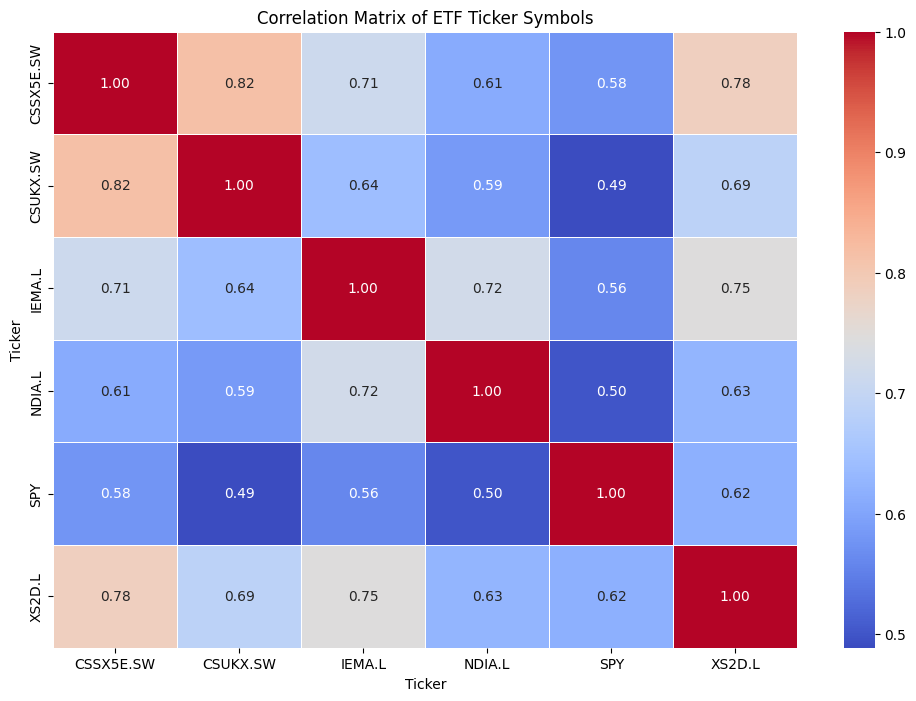


MSCI World Annual Return: 10.77%
MSCI World Standard Deviation: 18.37%
Total MSCI World Return: 37.84%

Optimal Allocation for Maximum Return:
CSSX5E.SW: 6.61%
CSUKX.SW: 5.35%
IEMA.L: 5.82%
NDIA.L: 20.21%
SPY: 13.44%
XS2D.L: 48.56%
Annual Return: 15.78%
Standard Deviation: 25.85%
Total Return: 65.06%

Optimal Allocation for Minimum Standard Deviation:
CSSX5E.SW: 11.15%
CSUKX.SW: 36.05%
IEMA.L: 10.23%
NDIA.L: 8.06%
SPY: 29.15%
XS2D.L: 5.35%
Annual Return: 9.41%
Standard Deviation: 17.02%
Total Return: 28.94%


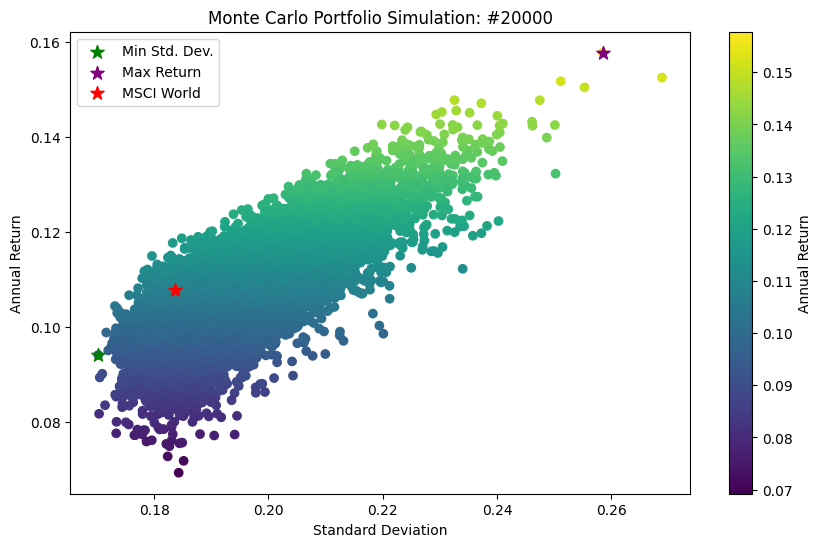

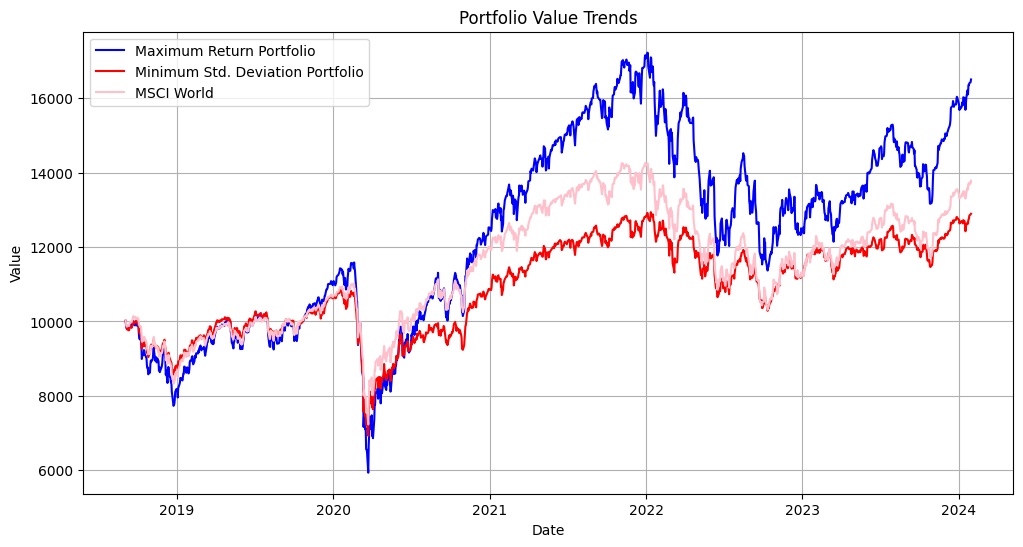

In [14]:
generate_simulation(0, True, True)

In [15]:
# Number of interactions
num_interactions = 500

# Step in days
step_days = 1

for day_to_add in range(num_interactions):
  percentage_interaction = day_to_add / num_interactions
  print(f"\n===============> {percentage_interaction:.2%}")
  generate_simulation(day_to_add * step_days, False, False)

[****************      33%%                      ]  2 of 6 completed


===============> 0.00%

days_to_add: 0


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[**********************50%%                      ]  3 of 6 completed


===============> 0.20%

days_to_add: 1


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 0.40%

days_to_add: 2


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 0.60%

days_to_add: 3


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 0.80%

days_to_add: 4


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 1.00%

days_to_add: 5


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 1.20%

days_to_add: 6


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 1.40%

days_to_add: 7


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 1.60%

days_to_add: 8


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 1.80%

days_to_add: 9


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 2.00%

days_to_add: 10


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 2.20%

days_to_add: 11


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 2.40%

days_to_add: 12


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 2.60%

days_to_add: 13


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 2.80%

days_to_add: 14


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 3.00%

days_to_add: 15


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 3.20%

days_to_add: 16


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 3.40%

days_to_add: 17


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 3.60%

days_to_add: 18


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed



===============> 3.80%

days_to_add: 19


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 4.00%

days_to_add: 20


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 4.20%

days_to_add: 21


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 4.40%

days_to_add: 22


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 4.60%

days_to_add: 23


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 4.80%

days_to_add: 24


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 5.00%

days_to_add: 25


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 5.20%

days_to_add: 26


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 5.40%

days_to_add: 27


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 5.60%

days_to_add: 28


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 5.80%

days_to_add: 29


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 6.00%

days_to_add: 30


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 6.20%

days_to_add: 31


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 6.40%

days_to_add: 32


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 6.60%

days_to_add: 33


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 6.80%

days_to_add: 34


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 7.00%

days_to_add: 35


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 7.20%

days_to_add: 36


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 7.40%

days_to_add: 37


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 7.60%

days_to_add: 38


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 7.80%

days_to_add: 39


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 8.00%

days_to_add: 40


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 8.20%

days_to_add: 41


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 8.40%

days_to_add: 42


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 8.60%

days_to_add: 43


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 8.80%

days_to_add: 44


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 9.00%

days_to_add: 45


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 9.20%

days_to_add: 46


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 9.40%

days_to_add: 47


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 9.60%

days_to_add: 48


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 9.80%

days_to_add: 49


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 10.00%

days_to_add: 50


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 10.20%

days_to_add: 51


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 10.40%

days_to_add: 52


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 10.60%

days_to_add: 53


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 10.80%

days_to_add: 54


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 11.00%

days_to_add: 55


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 11.20%

days_to_add: 56


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 11.40%

days_to_add: 57


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 11.60%

days_to_add: 58


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 11.80%

days_to_add: 59


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 12.00%

days_to_add: 60


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 12.20%

days_to_add: 61


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 12.40%

days_to_add: 62


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 12.60%

days_to_add: 63


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 12.80%

days_to_add: 64


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 13.00%

days_to_add: 65


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 13.20%

days_to_add: 66


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 13.40%

days_to_add: 67


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 13.60%

days_to_add: 68


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 13.80%

days_to_add: 69


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 14.00%

days_to_add: 70


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 14.20%

days_to_add: 71


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 14.40%

days_to_add: 72


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 14.60%

days_to_add: 73


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 14.80%

days_to_add: 74


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 15.00%

days_to_add: 75


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 15.20%

days_to_add: 76


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 15.40%

days_to_add: 77


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 15.60%

days_to_add: 78


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 15.80%

days_to_add: 79


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 16.00%

days_to_add: 80


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 16.20%

days_to_add: 81


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 16.40%

days_to_add: 82


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 16.60%

days_to_add: 83


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 16.80%

days_to_add: 84


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 17.00%

days_to_add: 85


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 17.20%

days_to_add: 86


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 17.40%

days_to_add: 87


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 17.60%

days_to_add: 88


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 17.80%

days_to_add: 89


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 18.00%

days_to_add: 90


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 18.20%

days_to_add: 91


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 18.40%

days_to_add: 92


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 18.60%

days_to_add: 93


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 18.80%

days_to_add: 94


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 19.00%

days_to_add: 95


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 19.20%

days_to_add: 96


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 19.40%

days_to_add: 97


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 19.60%

days_to_add: 98


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 19.80%

days_to_add: 99


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 20.00%

days_to_add: 100


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 20.20%

days_to_add: 101


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 20.40%

days_to_add: 102


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 20.60%

days_to_add: 103


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 20.80%

days_to_add: 104


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 21.00%

days_to_add: 105


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 21.20%

days_to_add: 106


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 21.40%

days_to_add: 107


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 21.60%

days_to_add: 108


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 21.80%

days_to_add: 109


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 22.00%

days_to_add: 110


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 22.20%

days_to_add: 111


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 22.40%

days_to_add: 112


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 22.60%

days_to_add: 113


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 22.80%

days_to_add: 114


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 23.00%

days_to_add: 115


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 23.20%

days_to_add: 116


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 23.40%

days_to_add: 117


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 23.60%

days_to_add: 118


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 23.80%

days_to_add: 119


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 24.00%

days_to_add: 120


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 24.20%

days_to_add: 121


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 24.40%

days_to_add: 122


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 24.60%

days_to_add: 123


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 24.80%

days_to_add: 124


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 25.00%

days_to_add: 125


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 25.20%

days_to_add: 126


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 25.40%

days_to_add: 127


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 25.60%

days_to_add: 128


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 25.80%

days_to_add: 129


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 26.00%

days_to_add: 130


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 26.20%

days_to_add: 131


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 26.40%

days_to_add: 132


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 26.60%

days_to_add: 133


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 26.80%

days_to_add: 134


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 27.00%

days_to_add: 135


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 27.20%

days_to_add: 136


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 27.40%

days_to_add: 137


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 27.60%

days_to_add: 138


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 27.80%

days_to_add: 139


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 28.00%

days_to_add: 140


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 28.20%

days_to_add: 141


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 28.40%

days_to_add: 142


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 28.60%

days_to_add: 143


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 28.80%

days_to_add: 144


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 29.00%

days_to_add: 145


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 29.20%

days_to_add: 146


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 29.40%

days_to_add: 147


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 29.60%

days_to_add: 148


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 29.80%

days_to_add: 149


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 30.00%

days_to_add: 150


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 30.20%

days_to_add: 151


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 30.40%

days_to_add: 152


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 30.60%

days_to_add: 153


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 30.80%

days_to_add: 154


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 31.00%

days_to_add: 155


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 31.20%

days_to_add: 156


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 31.40%

days_to_add: 157


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 31.60%

days_to_add: 158


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 31.80%

days_to_add: 159


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 32.00%

days_to_add: 160


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 32.20%

days_to_add: 161


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 32.40%

days_to_add: 162


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 32.60%

days_to_add: 163


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 32.80%

days_to_add: 164


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 33.00%

days_to_add: 165


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 33.20%

days_to_add: 166


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 33.40%

days_to_add: 167


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 33.60%

days_to_add: 168


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 33.80%

days_to_add: 169


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 34.00%

days_to_add: 170


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 34.20%

days_to_add: 171


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 34.40%

days_to_add: 172


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed



===============> 34.60%

days_to_add: 173


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 34.80%

days_to_add: 174


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 35.00%

days_to_add: 175


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 35.20%

days_to_add: 176


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 35.40%

days_to_add: 177


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 35.60%

days_to_add: 178


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 35.80%

days_to_add: 179


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 36.00%

days_to_add: 180


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 36.20%

days_to_add: 181


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 36.40%

days_to_add: 182


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 36.60%

days_to_add: 183


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 36.80%

days_to_add: 184


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 37.00%

days_to_add: 185


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 37.20%

days_to_add: 186


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 37.40%

days_to_add: 187


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 37.60%

days_to_add: 188


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 37.80%

days_to_add: 189


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 38.00%

days_to_add: 190


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 38.20%

days_to_add: 191


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 38.40%

days_to_add: 192


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 38.60%

days_to_add: 193


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 38.80%

days_to_add: 194


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 39.00%

days_to_add: 195


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 39.20%

days_to_add: 196


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 39.40%

days_to_add: 197


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 39.60%

days_to_add: 198


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 39.80%

days_to_add: 199


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 40.00%

days_to_add: 200


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 40.20%

days_to_add: 201


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 40.40%

days_to_add: 202


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 40.60%

days_to_add: 203


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 40.80%

days_to_add: 204


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 41.00%

days_to_add: 205


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 41.20%

days_to_add: 206


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 41.40%

days_to_add: 207


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 41.60%

days_to_add: 208


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 41.80%

days_to_add: 209


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 42.00%

days_to_add: 210


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 42.20%

days_to_add: 211


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 42.40%

days_to_add: 212


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 42.60%

days_to_add: 213


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 42.80%

days_to_add: 214


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 43.00%

days_to_add: 215


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 43.20%

days_to_add: 216


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 43.40%

days_to_add: 217


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 43.60%

days_to_add: 218


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 43.80%

days_to_add: 219


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 44.00%

days_to_add: 220


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 44.20%

days_to_add: 221


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 44.40%

days_to_add: 222


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 44.60%

days_to_add: 223


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 44.80%

days_to_add: 224


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 45.00%

days_to_add: 225


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 45.20%

days_to_add: 226


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 45.40%

days_to_add: 227


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 45.60%

days_to_add: 228


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 45.80%

days_to_add: 229


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 46.00%

days_to_add: 230


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 46.20%

days_to_add: 231


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 46.40%

days_to_add: 232


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 46.60%

days_to_add: 233


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 46.80%

days_to_add: 234


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 47.00%

days_to_add: 235


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 47.20%

days_to_add: 236


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 47.40%

days_to_add: 237


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 47.60%

days_to_add: 238


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 47.80%

days_to_add: 239


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 48.00%

days_to_add: 240


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 48.20%

days_to_add: 241


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 48.40%

days_to_add: 242


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 48.60%

days_to_add: 243


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 48.80%

days_to_add: 244


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 49.00%

days_to_add: 245


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 49.20%

days_to_add: 246


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 49.40%

days_to_add: 247


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 49.60%

days_to_add: 248


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 49.80%

days_to_add: 249


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 50.00%

days_to_add: 250


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 50.20%

days_to_add: 251


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 50.40%

days_to_add: 252


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 50.60%

days_to_add: 253


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 50.80%

days_to_add: 254


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 51.00%

days_to_add: 255


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 51.20%

days_to_add: 256


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 51.40%

days_to_add: 257


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 51.60%

days_to_add: 258


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 51.80%

days_to_add: 259


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 52.00%

days_to_add: 260


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 52.20%

days_to_add: 261


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 52.40%

days_to_add: 262


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 52.60%

days_to_add: 263


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 52.80%

days_to_add: 264


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 53.00%

days_to_add: 265


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 53.20%

days_to_add: 266


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 53.40%

days_to_add: 267


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 53.60%

days_to_add: 268


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 53.80%

days_to_add: 269


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 54.00%

days_to_add: 270


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 54.20%

days_to_add: 271


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 54.40%

days_to_add: 272


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 54.60%

days_to_add: 273


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 54.80%

days_to_add: 274


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 55.00%

days_to_add: 275


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 55.20%

days_to_add: 276


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 55.40%

days_to_add: 277


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 55.60%

days_to_add: 278


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 55.80%

days_to_add: 279


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed



===============> 56.00%

days_to_add: 280


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 56.20%

days_to_add: 281


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 56.40%

days_to_add: 282


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 56.60%

days_to_add: 283


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 56.80%

days_to_add: 284


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 57.00%

days_to_add: 285


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 57.20%

days_to_add: 286


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 57.40%

days_to_add: 287


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 57.60%

days_to_add: 288


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 57.80%

days_to_add: 289


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 58.00%

days_to_add: 290


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 58.20%

days_to_add: 291


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 58.40%

days_to_add: 292


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 58.60%

days_to_add: 293


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 58.80%

days_to_add: 294


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 59.00%

days_to_add: 295


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 59.20%

days_to_add: 296


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 59.40%

days_to_add: 297


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 59.60%

days_to_add: 298


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 59.80%

days_to_add: 299


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 60.00%

days_to_add: 300


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 60.20%

days_to_add: 301


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 60.40%

days_to_add: 302


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 60.60%

days_to_add: 303


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 60.80%

days_to_add: 304


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 61.00%

days_to_add: 305


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 61.20%

days_to_add: 306


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 61.40%

days_to_add: 307


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 61.60%

days_to_add: 308


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 61.80%

days_to_add: 309


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 62.00%

days_to_add: 310


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 62.20%

days_to_add: 311


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 62.40%

days_to_add: 312


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 62.60%

days_to_add: 313


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 62.80%

days_to_add: 314


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 63.00%

days_to_add: 315


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 63.20%

days_to_add: 316


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 63.40%

days_to_add: 317


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 63.60%

days_to_add: 318


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed



===============> 63.80%

days_to_add: 319


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 64.00%

days_to_add: 320


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 64.20%

days_to_add: 321


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 64.40%

days_to_add: 322


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 64.60%

days_to_add: 323


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 64.80%

days_to_add: 324


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 65.00%

days_to_add: 325


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 65.20%

days_to_add: 326


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 65.40%

days_to_add: 327


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 65.60%

days_to_add: 328


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 65.80%

days_to_add: 329


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 66.00%

days_to_add: 330


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 66.20%

days_to_add: 331


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 66.40%

days_to_add: 332


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 66.60%

days_to_add: 333


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 66.80%

days_to_add: 334


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 67.00%

days_to_add: 335


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 67.20%

days_to_add: 336


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 67.40%

days_to_add: 337


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 67.60%

days_to_add: 338


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 67.80%

days_to_add: 339


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 68.00%

days_to_add: 340


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 68.20%

days_to_add: 341


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 68.40%

days_to_add: 342


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 68.60%

days_to_add: 343


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 68.80%

days_to_add: 344


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 69.00%

days_to_add: 345


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 69.20%

days_to_add: 346


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 69.40%

days_to_add: 347


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 69.60%

days_to_add: 348


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 69.80%

days_to_add: 349


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 70.00%

days_to_add: 350


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 70.20%

days_to_add: 351


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 70.40%

days_to_add: 352


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 70.60%

days_to_add: 353


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 70.80%

days_to_add: 354


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 71.00%

days_to_add: 355


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 71.20%

days_to_add: 356


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 71.40%

days_to_add: 357


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 71.60%

days_to_add: 358


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 71.80%

days_to_add: 359


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 72.00%

days_to_add: 360


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 72.20%

days_to_add: 361


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 72.40%

days_to_add: 362


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 72.60%

days_to_add: 363


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 72.80%

days_to_add: 364


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 73.00%

days_to_add: 365


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 73.20%

days_to_add: 366


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 73.40%

days_to_add: 367


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 73.60%

days_to_add: 368


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 73.80%

days_to_add: 369


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 74.00%

days_to_add: 370


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 74.20%

days_to_add: 371


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 74.40%

days_to_add: 372


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 74.60%

days_to_add: 373


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 74.80%

days_to_add: 374


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 75.00%

days_to_add: 375


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 75.20%

days_to_add: 376


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 75.40%

days_to_add: 377


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 75.60%

days_to_add: 378


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 75.80%

days_to_add: 379


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 76.00%

days_to_add: 380


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 76.20%

days_to_add: 381


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 76.40%

days_to_add: 382


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 76.60%

days_to_add: 383


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 76.80%

days_to_add: 384


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 77.00%

days_to_add: 385


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 77.20%

days_to_add: 386


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 77.40%

days_to_add: 387


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 77.60%

days_to_add: 388


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 77.80%

days_to_add: 389


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 78.00%

days_to_add: 390


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 78.20%

days_to_add: 391


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 78.40%

days_to_add: 392


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 78.60%

days_to_add: 393


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 78.80%

days_to_add: 394


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 79.00%

days_to_add: 395


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 79.20%

days_to_add: 396


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 79.40%

days_to_add: 397


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 79.60%

days_to_add: 398


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 79.80%

days_to_add: 399


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 80.00%

days_to_add: 400


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 80.20%

days_to_add: 401


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 80.40%

days_to_add: 402


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 80.60%

days_to_add: 403


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 80.80%

days_to_add: 404


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 81.00%

days_to_add: 405


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 81.20%

days_to_add: 406


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 81.40%

days_to_add: 407


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 81.60%

days_to_add: 408


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 81.80%

days_to_add: 409


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 82.00%

days_to_add: 410


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 82.20%

days_to_add: 411


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 82.40%

days_to_add: 412


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 82.60%

days_to_add: 413


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 82.80%

days_to_add: 414


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 83.00%

days_to_add: 415


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 83.20%

days_to_add: 416


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 83.40%

days_to_add: 417


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 83.60%

days_to_add: 418


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 83.80%

days_to_add: 419


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 84.00%

days_to_add: 420


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 84.20%

days_to_add: 421


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 84.40%

days_to_add: 422


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 84.60%

days_to_add: 423


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 84.80%

days_to_add: 424


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 85.00%

days_to_add: 425


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 85.20%

days_to_add: 426


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 85.40%

days_to_add: 427


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 85.60%

days_to_add: 428


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 85.80%

days_to_add: 429


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 86.00%

days_to_add: 430


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 86.20%

days_to_add: 431


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 86.40%

days_to_add: 432


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 86.60%

days_to_add: 433


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 86.80%

days_to_add: 434


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 87.00%

days_to_add: 435


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 87.20%

days_to_add: 436


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 87.40%

days_to_add: 437


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 87.60%

days_to_add: 438


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 87.80%

days_to_add: 439


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 88.00%

days_to_add: 440


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 88.20%

days_to_add: 441


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 88.40%

days_to_add: 442


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 88.60%

days_to_add: 443


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 88.80%

days_to_add: 444


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 89.00%

days_to_add: 445


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 89.20%

days_to_add: 446


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 89.40%

days_to_add: 447


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 89.60%

days_to_add: 448


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 89.80%

days_to_add: 449


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 90.00%

days_to_add: 450


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 90.20%

days_to_add: 451


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 90.40%

days_to_add: 452


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 90.60%

days_to_add: 453


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 90.80%

days_to_add: 454


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 91.00%

days_to_add: 455


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 91.20%

days_to_add: 456


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 91.40%

days_to_add: 457


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 91.60%

days_to_add: 458


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 91.80%

days_to_add: 459


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 92.00%

days_to_add: 460


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 92.20%

days_to_add: 461


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 92.40%

days_to_add: 462


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 92.60%

days_to_add: 463


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 92.80%

days_to_add: 464


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 93.00%

days_to_add: 465


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 93.20%

days_to_add: 466


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 93.40%

days_to_add: 467


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 93.60%

days_to_add: 468


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 93.80%

days_to_add: 469


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 94.00%

days_to_add: 470


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 94.20%

days_to_add: 471


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 94.40%

days_to_add: 472


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 94.60%

days_to_add: 473


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 94.80%

days_to_add: 474


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 95.00%

days_to_add: 475


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 95.20%

days_to_add: 476


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 95.40%

days_to_add: 477


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 95.60%

days_to_add: 478


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 95.80%

days_to_add: 479


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 96.00%

days_to_add: 480


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 96.20%

days_to_add: 481


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 96.40%

days_to_add: 482


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 96.60%

days_to_add: 483


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 96.80%

days_to_add: 484


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 97.00%

days_to_add: 485


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 97.20%

days_to_add: 486


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 97.40%

days_to_add: 487


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 97.60%

days_to_add: 488


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[****************      33%%                      ]  2 of 6 completed


===============> 97.80%

days_to_add: 489


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 98.00%

days_to_add: 490


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 98.20%

days_to_add: 491


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 98.40%

days_to_add: 492


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 98.60%

days_to_add: 493


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 98.80%

days_to_add: 494


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 99.00%

days_to_add: 495


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 99.20%

days_to_add: 496


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 99.40%

days_to_add: 497


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 99.60%

days_to_add: 498


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]


===============> 99.80%

days_to_add: 499


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed


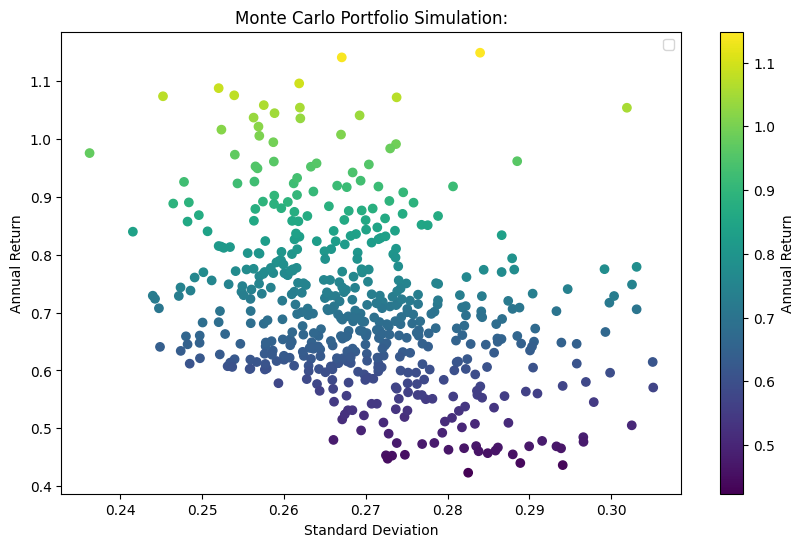

In [16]:
# Calculate and display the optimal allocation with maximum return
max_return_index = np.argmax(list_max_return)
optimal_allocation = list_max_return_allocation[max_return_index]
max_return_startdate = list_max_return_startdate[max_return_index]

# Generate a 2D plot showing the relationship between standard deviation and annual return
plt.figure(figsize=(10, 6))
plt.scatter(list_std_dev, list_max_return, c=list_max_return, cmap='viridis')
plt.colorbar(label='Annual Return')
plt.xlabel('Standard Deviation')
plt.ylabel('Annual Return')
plt.title(f'Monte Carlo Portfolio Simulation:')
plt.legend()
plt.show()

In [17]:
# Calculate the minimum
min_returns = min(list_max_return)

# Calculate the maximum
max_returns = max(list_max_return)

# Calculate the mean
avg_returns = sum(list_max_return) / len(list_max_return)

# Calculate the median
median_returns = statistics.median(list_max_return)

# Print the results
print(f"Minimum: {min_returns:.2%}")
print(f"Maximum: {max_returns:.2%}")
print(f"Mean: {avg_returns:.2%}")
print(f"Median: {median_returns:.2%}")

Minimum: 42.34%
Maximum: 114.85%
Mean: 70.42%
Median: 68.83%


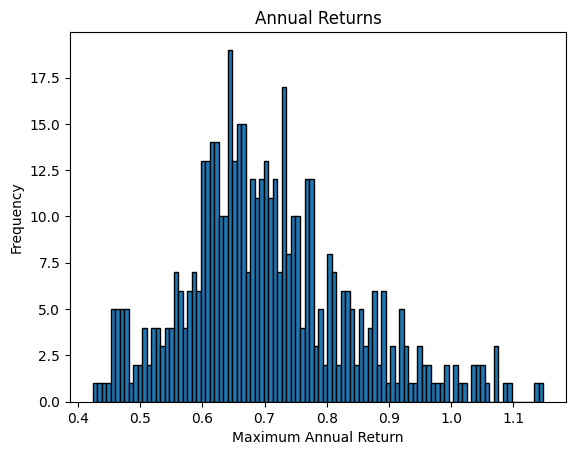

In [18]:
# Create a histogram to visualize the data distribution
plt.hist(list_max_return, bins=100, edgecolor='black')
plt.title('Annual Returns')
plt.xlabel('Maximum Annual Return')
plt.ylabel('Frequency')
plt.show()